### Task 105: Simulate Non-rebasing token being deposited and traded against rebasing token
* Simulate CPT trading with a non-rebasing toke paired with a rebasing token.

In [1]:
import os
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
cwd =  os.getcwd().replace("notebooks/test","")
os.chdir(cwd)

from python.dev.event.state.series import StateSeries
from python.dev.event.state import State
from python.dev.event import Deposit
from python.dev.event import Withdraw
from python.dev.token.trade import Convert
from python.dev.cpt import Liquidity
from python.dev.cpt import PriceCurve
from python.dev.cpt import ConstantProductTrade
from python.dev.plot import PlotPriceCurve
from python.dev.token import RebaseToken
from python.dev.token import NonRebaseToken
from python.dev.math.model import TimeDeltaModel
from python.dev.math.model import TokenDeltaModel
from python.dev.math.model import EventSelectionModel

### Part A: individually step through each of the instructions

* Initialize Rebasing and Non-rebasing tokens along with liquidity pool

In [2]:
# Initialize Rebasing/NonRebasing Tokens
APY = 0.1

TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TYPE_COLLATERAL_TOKEN = 'COLLATERAL'

time_delta = TimeDeltaModel().apply()
depositT1 = 10000  

T1 = NonRebaseToken(TYPE_DEPOSIT_TOKEN)
t1Address = T1.mint(depositT1)

time_delta = TimeDeltaModel().apply()
depositTCT1 = 10000 

TCT1 = RebaseToken(TYPE_COLLATERAL_TOKEN)
tctAddress = TCT1.mint(depositTCT1, APY)

x = T1.get_balance_deposits()
y = TCT1.get_balance_deposits()

# Initialize Liquidity Pool
liq = Liquidity(x,y)
L = liq.calc(); p = np.random.normal(5,0.1,1)[0]
cpt = ConstantProductTrade(L)
pCurve = PriceCurve(L)

print('[Initial] T1: {:.2f} TCT1: {:.2f} L: {:.5f}\n'.format(x,y,L))

[Initial] T1: 10000.00 TCT1: 10000.00 L: 10000.00000



* The deposit event that includes the amount of non-rebasing token will expand the supply of the rebasing token 1:1

In [3]:
token_delta = TokenDeltaModel(1,100).apply() 
time_delta = TimeDeltaModel().apply() 
T1.add_event(Deposit(0, token_delta, time_delta, t1Address))
TCT1.add_event(Deposit(APY, token_delta, time_delta, tctAddress)) 

TCT1_yield = TCT1.get_state_series(tctAddress).get_last_state().get_yield()

x = T1.get_balance_deposits()
y = TCT1.get_balance_deposits()

liq.delta_y(token_delta+TCT1_yield)
liq.delta_x(token_delta) 
L = liq.calc()

print('[Deposits] T1: {:.5f} TCT1: {:.5f} L: {:.5f}'.format(x,y,L))


[Deposits] T1: 10042.97836 TCT1: 10045.50680 L: 10044.24250


* The subsequent trade must be for the same amount being deposited.
* The amount of rebasing token purchase must be reflected as having left CPT liquidity.

In [4]:
T1.add_event(Withdraw(0, token_delta, 0, t1Address))
TCT1.add_event(Deposit(APY, token_delta, 0, tctAddress)) 

TCT1_yield = TCT1.get_state_series(tctAddress).get_last_state().get_yield()
liq.delta_y(TCT1_yield)
L = liq.swap(token_delta)

x = T1.get_balance_deposits()
y = TCT1.get_balance_deposits()

print('[Swap] T1: {:.5f} TCT1: {:.5f} L: {:.5f}'.format(x,y,L))


[Swap] T1: 10000.00000 TCT1: 10088.48516 L: 10044.24250


### Part B: running through each of the above instructions through a loop

In [5]:
# Initialize Rebasing/NonRebasing Tokens
APY = 0.1

TYPE_DEPOSIT_TOKEN = 'DEPOSIT'
TYPE_COLLATERAL_TOKEN = 'COLLATERAL'

time_delta = TimeDeltaModel().apply()
depositT1 = 10000  

T1 = NonRebaseToken(TYPE_DEPOSIT_TOKEN)
t1Address = T1.mint(depositT1)

time_delta = TimeDeltaModel().apply()
depositTCT1 = 10000 

TCT1 = RebaseToken(TYPE_COLLATERAL_TOKEN)
tctAddress = TCT1.mint(depositTCT1, APY)

x = T1.get_balance_deposits()
y = TCT1.get_balance_deposits()

# Initialize Liquidity Pool
liq = Liquidity(x,y)
L = liq.calc(); p = np.random.normal(5,0.1,1)[0]

print('[Initial] T1: {:.2f} TCT1: {:.2f} L: {:.5f}\n'.format(x,y,L))

[Initial] T1: 10000.00 TCT1: 10000.00 L: 10000.00000



[0. Deposits] T1: 10063.95775 TCT1: 10064.81806 L: 10064.38790
[0. Swap] T1: 10000.00000 TCT1: 10128.77581 L: 10064.38790

[50. Deposits] T1: 10066.92174 TCT1: 20371.37705 L: 15329.16312
[50. Swap] T1: 10000.00000 TCT1: 20438.29879 L: 15329.16312

[100. Deposits] T1: 10053.23855 TCT1: 28626.70997 L: 19707.99514
[100. Swap] T1: 10000.00000 TCT1: 28679.94852 L: 19707.99514

[150. Deposits] T1: 10018.68604 TCT1: 40042.37456 L: 25923.42299
[150. Swap] T1: 10000.00000 TCT1: 40061.06060 L: 25923.42299

[200. Deposits] T1: 10004.00972 TCT1: 50935.39202 L: 32004.62930
[200. Swap] T1: 10000.00000 TCT1: 50939.40174 L: 32004.62930



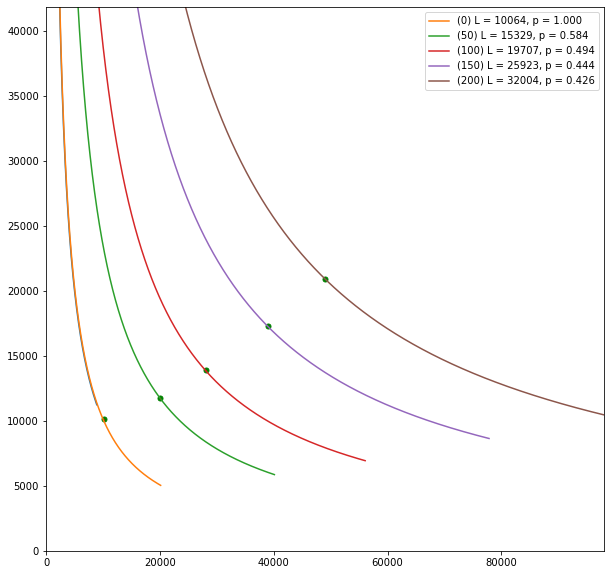

In [6]:
# Plot and execute N trades
percent = 0.05
N = 250

cpt = ConstantProductTrade(L)
pCurve = PriceCurve(L)
plotCurve = PlotPriceCurve(L, cpt, pCurve)
plotCurve.apply(p, None)

for k in range(N):
    
    # The deposit event that includes the amount of non-rebasing token will 
    # expand the supply of the rebasing token 1:1
    
    token_delta = TokenDeltaModel(1,100).apply() 
    time_delta = TimeDeltaModel().apply() 
    T1.add_event(Deposit(0, token_delta, time_delta, t1Address))
    TCT1.add_event(Deposit(APY, token_delta, time_delta, tctAddress)) 

    TCT1_yield = TCT1.get_state_series(tctAddress).get_last_state().get_yield()

    x = T1.get_balance_deposits()
    y = TCT1.get_balance_deposits()

    liq.delta_x(token_delta)
    liq.delta_y(token_delta+TCT1_yield)     
    L = liq.calc(); #p = np.random.normal(5,0.1,1)[0]
    p = liq.get_swap_price()

    if (k % int(N/(100*percent)) == 0): 
        print('[{}. Deposits] T1: {:.5f} TCT1: {:.5f} L: {:.5f}'.format(k,x,y,L))
    
    # The subsequent trade must be for the same amount being deposited
    
    T1.add_event(Withdraw(0, token_delta, 0, t1Address))
    TCT1.add_event(Deposit(APY, token_delta, 0, tctAddress)) 

    # The amount of rebasing token purchase must be reflected as having 
    # left CPT liquidity.

    TCT1_yield = TCT1.get_state_series(tctAddress).get_last_state().get_yield()
    liq.delta_y(TCT1_yield)
    L = liq.swap(token_delta)

    x = T1.get_balance_deposits()
    y = TCT1.get_balance_deposits()

    if (k % int(N/(100*percent)) == 0):
        plotCurve.apply_next(p, L, '({}) L = {}, p = {:.3f}'.format(k, int(L),p))
        plotCurve.plot_trade(p, token_delta, 'r--')        
        print('[{}. Swap] T1: {:.5f} TCT1: {:.5f} L: {:.5f}\n'.format(k,x,y,L))    



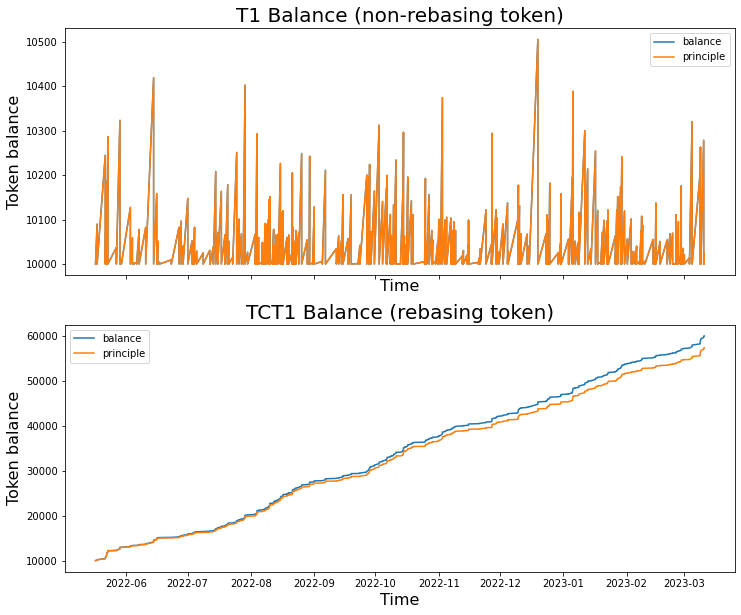

In [7]:
# Analyze Token balances

T1_states = T1.get_state_series(t1Address)
principle = T1_states.get_principle() 
balance = T1_states.get_balance() 
tSamp = T1_states.get_tstamp()  

fig, (T1_ax, TCT1_ax) = plt.subplots(nrows=2, sharex=True, sharey=False, figsize=(12, 10))

T1_ax.plot(tSamp[1:], balance[1:], label='balance') 
T1_ax.plot(tSamp[1:], principle[1:], label='principle') 
T1_ax.set_title("T1 Balance (non-rebasing token)", fontsize=20)
T1_ax.set_ylabel("Token balance", fontsize=16)
T1_ax.set_xlabel('Time', fontsize=16)
T1_ax.legend()

TCT1_states = TCT1.get_state_series(tctAddress)
principle = TCT1_states.get_principle() 
balance = TCT1_states.get_balance() 
tSamp = TCT1_states.get_tstamp() 

TCT1_ax.plot(tSamp[1:], balance[1:], label='balance') 
TCT1_ax.plot(tSamp[1:], principle[1:], label='principle') 
TCT1_ax.set_title("TCT1 Balance (rebasing token)", fontsize=20)
TCT1_ax.set_ylabel("Token balance", fontsize=16)
TCT1_ax.set_xlabel('Time', fontsize=16)
TCT1_ax.legend()
